In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


In [10]:
# Defs

def apply_noise(label):
    if np.random.rand() < 0.25: 
        return 1 - label
    return label

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)

columns_to_drop = [
    'For Profit', 'Location', 'Personal Credit Score', 'Business Credit Score',
    'DSCR (2 years ago)', 'DSCR (1 year ago)', 'DSCR (latest year)', 'Loan Amount',
    'Industry Experience', 'Fast Approval'
]

In [ ]:
### Cleaning
df = pd.read_csv('Synthetic_SBA_Loans.csv')
df['Target_7a'] = df['Eligibility'].apply(lambda x: '7(a)' in str(x))
df['Target_7a'] = df['Target_7a'].astype(int)
df = df.drop(columns=['Applicant ID','Country','Eligibility','NAICS'])
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    df[col] = df[col].astype('category')

categorical_columns2 = df.drop(columns=[
    'Business Structure', 'For Profit', 'Location', 'Personal Credit Score', 'Business Credit Score',
    'DSCR (2 years ago)', 'DSCR (1 year ago)', 'DSCR (latest year)', 'Loan Amount',
    'Industry Experience', 'Fast Approval','Target_7a'
])

c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 357369, number of negative: 357369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4367
[LightGBM] [Info] Number of data points in the train set: 714738, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Results:
              precision    recall  f1-score   support

           0       0.26      0.07      0.11     29757
           1       0.75      0.93      0.83     89381

    accuracy                           0.72    119138
   macro avg       0.50      0.50      0.47    119138
weighted avg       0.63      0.72      0.65    119138

ROC-AUC: 0.5008



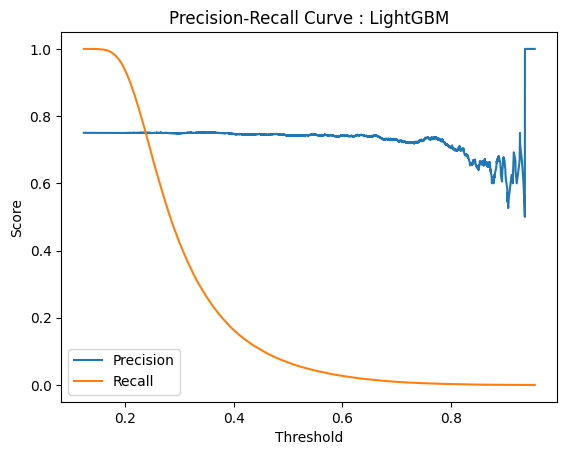

c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [02:20:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.26      0.08      0.13     29757
           1       0.75      0.92      0.83     89381

    accuracy                           0.71    119138
   macro avg       0.50      0.50      0.48    119138
weighted avg       0.63      0.71      0.65    119138

ROC-AUC: 0.5004



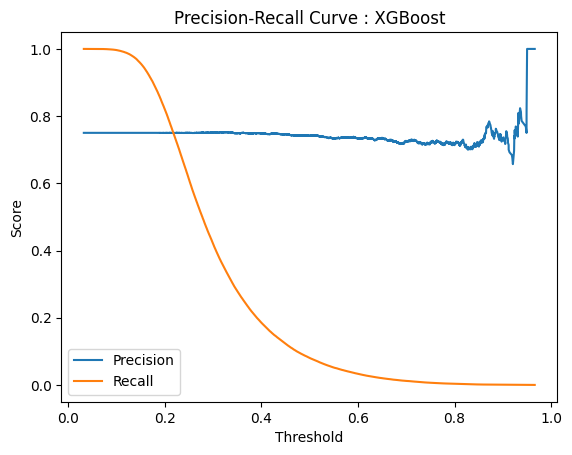

KeyboardInterrupt: 

In [12]:
### Noisy 25%
loans_df = df
loans_df["Target_7a"] = loans_df["Target_7a"].apply(apply_noise)

# Feature selection
X = loans_df.drop(columns=['Target_7a'])  
y = loans_df['Target_7a']

encoded_X = X.copy()
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    encoded_X[col] = le.fit_transform(encoded_X[col])
    label_encoders[col] = le  # Store for inverse transformation if needed

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Models dictionary
models = {
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(enable_categorical=True, scale_pos_weight=(y_train_resampled.value_counts()[0] / y_train_resampled.value_counts()[1]), 
                               random_state=42, use_label_encoder=True, eval_metric='logloss'),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression" : LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
    "RandomForest" : RandomForestClassifier(class_weight='balanced', random_state=42),
    "CatBoost" : CatBoostClassifier(auto_class_weights='Balanced',random_state=42, verbose=0)
}
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    probs = model.predict_proba(X_test)[:, 1]
    y_pred = (probs > 0.5).astype(int)
    
    print(f"{name} Results:")
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, probs)
    print(f"ROC-AUC: {roc_auc:.4f}\n")
    
    precision, recall, thresholds = precision_recall_curve(y_test, 1-probs)
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.title(f'Precision-Recall Curve : {name}')
    plt.show()

c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 297806, number of negative: 297806
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2797
[LightGBM] [Info] Number of data points in the train set: 595612, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Results:
              precision    recall  f1-score   support

           0       0.37      0.14      0.21     44780
           1       0.62      0.86      0.72     74358

    accuracy                           0.59    119138
   macro avg       0.50      0.50      0.46    119138
weighted avg       0.53      0.59      0.53    119138

ROC-AUC: 0.4991



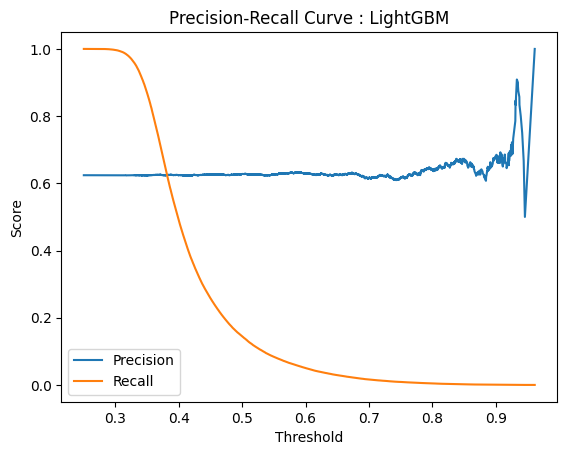

c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [00:59:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.37      0.16      0.22     44780
           1       0.62      0.84      0.72     74358

    accuracy                           0.58    119138
   macro avg       0.50      0.50      0.47    119138
weighted avg       0.53      0.58      0.53    119138

ROC-AUC: 0.4980



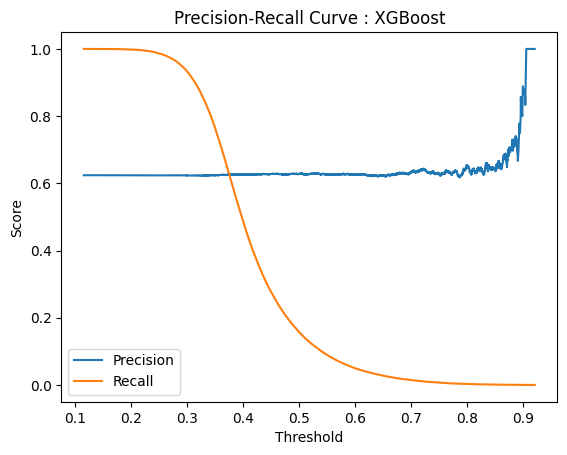

GradientBoosting Results:
              precision    recall  f1-score   support

           0       0.38      0.28      0.32     44780
           1       0.62      0.72      0.67     74358

    accuracy                           0.56    119138
   macro avg       0.50      0.50      0.49    119138
weighted avg       0.53      0.56      0.54    119138

ROC-AUC: 0.4985



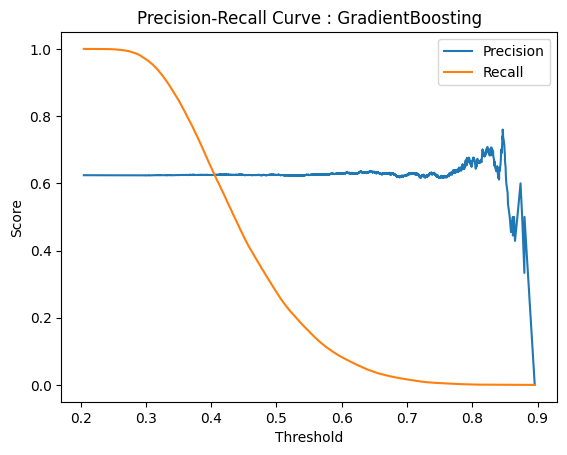

LogisticRegression Results:
              precision    recall  f1-score   support

           0       0.37      0.36      0.37     44780
           1       0.62      0.64      0.63     74358

    accuracy                           0.53    119138
   macro avg       0.50      0.50      0.50    119138
weighted avg       0.53      0.53      0.53    119138

ROC-AUC: 0.4991



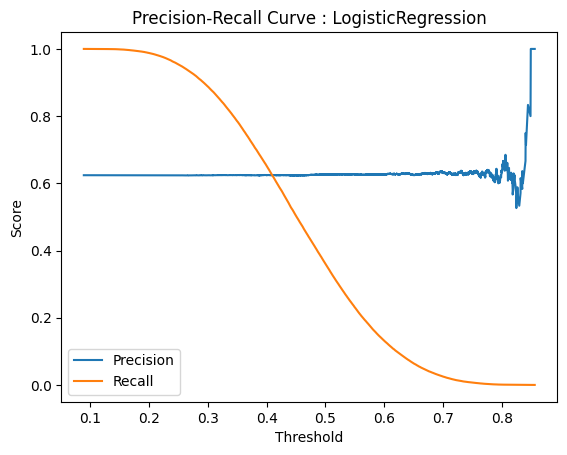

RandomForest Results:
              precision    recall  f1-score   support

           0       0.38      0.22      0.28     44780
           1       0.62      0.78      0.69     74358

    accuracy                           0.57    119138
   macro avg       0.50      0.50      0.49    119138
weighted avg       0.53      0.57      0.54    119138

ROC-AUC: 0.5007



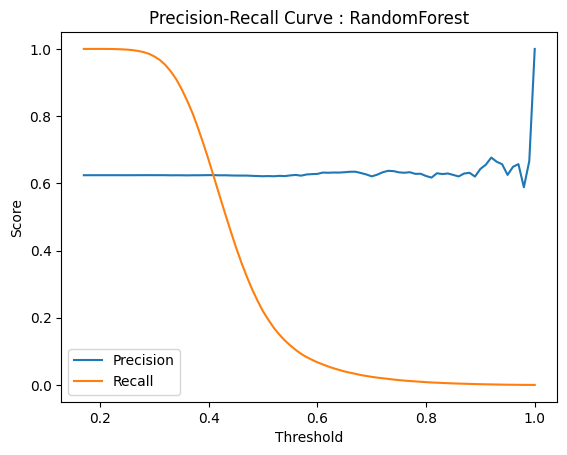

CatBoost Results:
              precision    recall  f1-score   support

           0       0.37      0.11      0.17     44780
           1       0.62      0.89      0.73     74358

    accuracy                           0.60    119138
   macro avg       0.50      0.50      0.45    119138
weighted avg       0.53      0.60      0.52    119138

ROC-AUC: 0.4995



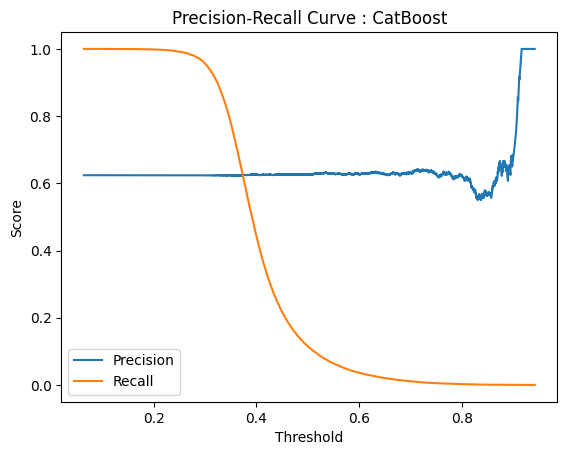

In [ ]:
### Noisy $ Dropped Columns
loans_df = df
loans_df["Target_7a"] = loans_df["Target_7a"].apply(apply_noise)

# Feature selection
X = loans_df.drop(columns=['Target_7a'])  

X = X.drop(columns=columns_to_drop)
y = loans_df['Target_7a']

encoded_X = X.copy()
label_encoders = {}
for col in categorical_columns2:
    le = LabelEncoder()
    encoded_X[col] = le.fit_transform(encoded_X[col])
    label_encoders[col] = le  # Store for inverse transformation if needed

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(encoded_X, y, test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Models dictionary
models = {
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(enable_categorical=True, scale_pos_weight=(y_train_resampled.value_counts()[0] / y_train_resampled.value_counts()[1]), 
                               random_state=42, use_label_encoder=True, eval_metric='logloss'),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LogisticRegression" : LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
    "RandomForest" : RandomForestClassifier(class_weight='balanced', random_state=42),
    "CatBoost" : CatBoostClassifier(auto_class_weights='Balanced',random_state=42, verbose=0)
}
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    probs = model.predict_proba(X_test)[:, 1]
    y_pred = (probs > 0.5).astype(int)
    
    print(f"{name} Results:")
    print(classification_report(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, probs)
    print(f"ROC-AUC: {roc_auc:.4f}\n")
    
    precision, recall, thresholds = precision_recall_curve(y_test, 1-probs)
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.title(f'Precision-Recall Curve : {name}')
    plt.show()

In [ ]:
import joblib
import os

# Make a folder to store the models (optional)
os.makedirs("saved_models", exist_ok=True)

# Save each trained model
for name, model in models.items():
    print(f"{name}: {type(model)}")
    file_path = os.path.join("saved_models", f"{name}_model.pkl")
    joblib.dump(model, file_path)
    print(f"Saved {name} model to {file_path}")

LightGBM: <class 'lightgbm.sklearn.LGBMClassifier'>
Saved LightGBM model to saved_models\LightGBM_model.pkl
XGBoost: <class 'xgboost.sklearn.XGBClassifier'>
Saved XGBoost model to saved_models\XGBoost_model.pkl
GradientBoosting: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Saved GradientBoosting model to saved_models\GradientBoosting_model.pkl
LogisticRegression: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Saved LogisticRegression model to saved_models\LogisticRegression_model.pkl
RandomForest: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Saved RandomForest model to saved_models\RandomForest_model.pkl
CatBoost: <class 'catboost.core.CatBoostClassifier'>
Saved CatBoost model to saved_models\CatBoost_model.pkl


In [ ]:
X.columns

Index(['Business Ownership (1)', 'Business Ownership (2)',
       'Business Ownership (3)', 'Business Ownership (4)',
       'Business Ownership (5)', 'Annual Revenue (2 years ago)',
       'Annual Revenue (1 year ago)', 'Annual Revenue (latest year)',
       'Net Profit Margin', 'Business Debt (2 years ago)',
       'Business Debt (1 year ago)', 'Business Debt (latest year)',
       'NOI (2 years ago)', 'NOI (1 year ago)', 'NOI (latest year)',
       'Managerial Experience', 'Years in Business', 'Collateral Availability',
       'Acquisition Request', 'Working Capital', 'Business Expansion',
       'Equipment Purchase or Leasing', 'Inventory Purchase',
       'Real Estate Acquisition or Improvement',
       'Business Acquisition or Buyout', 'Refinancing Existing Debt',
       'Emergency Funds', 'Franchise Financing', 'Contract Financing',
       'Licensing or Permits', 'Line of Credit Establishment',
       'Eligibility Score'],
      dtype='object')